In [ ]:
!nvidia-smi

Tue Dec 19 01:22:59 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from glob import glob
import os
import tensorflow as tf
from typing import List

import keras
from keras.optimizers import Adam


In [ ]:
!pip install -q wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.2 MB/s eta 0:00:00


In [ ]:
from wandb.keras import WandbCallback

In [ ]:
import gdown
import wandb
import subprocess
from matplotlib import pyplot as plt

In [ ]:
def read_images(image_files):
    dataset = tf.data.Dataset.from_tensor_slices(image_files)
    dataset = dataset.map(tf.io.read_file)
    dataset = dataset.map(
        lambda x: tf.image.decode_png(x, channels=3),
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    return dataset


def random_crop(low_image, enhanced_image, low_crop_size, enhanced_crop_size):
    low_image_shape = tf.shape(low_image)[:2]
    low_w = tf.random.uniform(
        shape=(), maxval=low_image_shape[1] - low_crop_size + 1, dtype=tf.int32)
    low_h = tf.random.uniform(
        shape=(), maxval=low_image_shape[0] - low_crop_size + 1, dtype=tf.int32)
    enhanced_w = low_w
    enhanced_h = low_h
    low_image_cropped = low_image[
                        low_h:low_h + low_crop_size,
                        low_w:low_w + low_crop_size
                        ]
    enhanced_image_cropped = enhanced_image[
                             enhanced_h:enhanced_h + enhanced_crop_size,
                             enhanced_w:enhanced_w + enhanced_crop_size
                             ]
    return low_image_cropped, enhanced_image_cropped


def random_flip(low_image, enhanced_image):
    return tf.cond(
        tf.random.uniform(shape=(), maxval=1) < 0.5,
        lambda: (low_image, enhanced_image),
        lambda: (
            tf.image.flip_left_right(low_image),
            tf.image.flip_left_right(enhanced_image)
        )
    )


def random_rotate(low_image, enhanced_image):
    condition = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    return tf.image.rot90(low_image, condition), tf.image.rot90(enhanced_image, condition)


def apply_scaling(low_image, enhanced_image):
    low_image = tf.cast(low_image, tf.float32)
    enhanced_image = tf.cast(enhanced_image, tf.float32)
    low_image = low_image / 255.0
    enhanced_image = enhanced_image / 255.0
    return low_image, enhanced_image


In [ ]:
class LOLDataLoader:

    def __init__(self, images_lowlight: List[str], images_highlight: List[str]):
        self.images_lowlight = images_lowlight
        self.images_highlight = images_highlight

    def __len__(self):
        assert len(self.images_lowlight) == len(self.images_enhanced)
        return len(self.images_lowlight)

    def build_dataset(self, image_crop_size: int, batch_size: int, is_dataset_train: bool):
        low_light_dataset = read_images(self.images_lowlight)
        high_light_dataset = read_images(self.images_highlight)
        dataset = tf.data.Dataset.zip((low_light_dataset, high_light_dataset))
        dataset = dataset.map(apply_scaling, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        dataset = dataset.map(
            lambda low, high: random_crop(low, high, image_crop_size, image_crop_size),
            num_parallel_calls=tf.data.experimental.AUTOTUNE
        )
        if is_dataset_train:
            dataset = dataset.map(random_rotate, num_parallel_calls=tf.data.experimental.AUTOTUNE)
            dataset = dataset.map(random_flip, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(batch_size)
        dataset = dataset.repeat(1)
        dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return dataset


In [ ]:

def spatial_attention_block(input_tensor):
    """Spatial Attention Block"""
    average_pooling = tf.reduce_max(input_tensor, axis=-1)
    average_pooling = tf.expand_dims(average_pooling, axis=-1)
    max_pooling = tf.reduce_mean(input_tensor, axis=-1)
    max_pooling = tf.expand_dims(max_pooling, axis=-1)
    concatenated = tf.keras.layers.Concatenate(axis=-1)([average_pooling, max_pooling])
    feature_map = tf.keras.layers.Conv2D(1, kernel_size=(1, 1))(concatenated)
    feature_map = tf.nn.sigmoid(feature_map)
    return input_tensor * feature_map


def channel_attention_block(input_tensor):
    """Channel Attention Block"""
    channels = list(input_tensor.shape)[-1]
    average_pooling = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
    feature_descriptor = tf.reshape(average_pooling, shape=(-1, 1, 1, channels))
    feature_activations = tf.keras.layers.ReLU()(
        tf.keras.layers.Conv2D(
            filters=channels // 8, kernel_size=(1, 1)
        )(feature_descriptor)
    )
    feature_activations = tf.nn.sigmoid(
        tf.keras.layers.Conv2D(
            filters=channels, kernel_size=(1, 1)
        )(feature_activations)
    )
    return input_tensor * feature_activations

In [ ]:
def dual_attention_unit_block(input_tensor):
    """Dual Attention Unit Block"""
    channels = list(input_tensor.shape)[-1]
    feature_map = tf.keras.layers.Conv2D(
        channels, kernel_size=(3, 3), padding='same')(input_tensor)
    feature_map = tf.keras.layers.ReLU()(feature_map)
    feature_map = tf.keras.layers.Conv2D(
        channels, kernel_size=(3, 3), padding='same')(feature_map)
    channel_attention = channel_attention_block(feature_map)
    spatial_attention = spatial_attention_block(feature_map)
    concatenation = tf.keras.layers.Concatenate(axis=-1)([
        channel_attention, spatial_attention])
    concatenation = tf.keras.layers.Conv2D(channels, kernel_size=(1, 1))(concatenation)
    return tf.keras.layers.Add()([input_tensor, concatenation])


In [ ]:

def selective_kernel_feature_fusion(
        multi_scale_feature_1, multi_scale_feature_2, multi_scale_feature_3):
    """Selective Kernel Feature Fusion Block"""
    channels = list(multi_scale_feature_1.shape)[-1]
    combined_feature = tf.keras.layers.Add()([
        multi_scale_feature_1, multi_scale_feature_2, multi_scale_feature_3])
    gap = tf.keras.layers.GlobalAveragePooling2D()(combined_feature)
    channel_wise_statistics = tf.reshape(gap, shape=(-1, 1, 1, channels))
    compact_feature_representation = tf.keras.layers.ReLU()(
        tf.keras.layers.Conv2D(
            filters=channels // 8, kernel_size=(1, 1)
        )(channel_wise_statistics)
    )
    feature_descriptor_1 = tf.nn.softmax(
        tf.keras.layers.Conv2D(channels, kernel_size=(1, 1))(compact_feature_representation)
    )
    feature_descriptor_2 = tf.nn.softmax(
        tf.keras.layers.Conv2D(channels, kernel_size=(1, 1))(compact_feature_representation)
    )
    feature_descriptor_3 = tf.nn.softmax(
        tf.keras.layers.Conv2D(channels, kernel_size=(1, 1))(compact_feature_representation)
    )
    feature_1 = multi_scale_feature_1 * feature_descriptor_1
    feature_2 = multi_scale_feature_2 * feature_descriptor_2
    feature_3 = multi_scale_feature_3 * feature_descriptor_3
    aggregated_feature = tf.keras.layers.Add()([feature_1, feature_2, feature_3])
    return aggregated_feature

def down_sampling_module(input_tensor):
    """Downsampling Module"""
    channels = list(input_tensor.shape)[-1]
    main_branch = tf.keras.layers.Conv2D(
        channels, kernel_size=(1, 1))(input_tensor)
    main_branch = tf.nn.relu(main_branch)
    # main_branch = tf.keras.layers.Conv2D(
    #     channels, kernel_size=(3, 3), padding='same')(input_tensor)
    main_branch = tf.keras.layers.Conv2D(
        channels, kernel_size=(3, 3), padding='same')(main_branch)
    main_branch = tf.nn.relu(main_branch)
    main_branch = tf.keras.layers.MaxPooling2D()(main_branch)
    main_branch = tf.keras.layers.Conv2D(
        channels * 2, kernel_size=(1, 1))(main_branch)
    skip_branch = tf.keras.layers.MaxPooling2D()(input_tensor)
    skip_branch = tf.keras.layers.Conv2D(
        channels * 2, kernel_size=(1, 1))(skip_branch)
    return tf.keras.layers.Add()([skip_branch, main_branch])


def up_sampling_module(input_tensor):
    """Upsampling Module"""
    channels = list(input_tensor.shape)[-1]
    main_branch = tf.keras.layers.Conv2D(
        channels, kernel_size=(1, 1))(input_tensor)
    main_branch = tf.nn.relu(main_branch)
    # main_branch = tf.keras.layers.Conv2D(
    #     channels, kernel_size=(3, 3), padding='same')(input_tensor)
    main_branch = tf.keras.layers.Conv2D(
        channels, kernel_size=(3, 3), padding='same')(main_branch)
    main_branch = tf.nn.relu(main_branch)
    main_branch = tf.keras.layers.UpSampling2D()(main_branch)
    main_branch = tf.keras.layers.Conv2D(
        channels // 2, kernel_size=(1, 1))(main_branch)
    skip_branch = tf.keras.layers.UpSampling2D()(input_tensor)
    skip_branch = tf.keras.layers.Conv2D(
        channels // 2, kernel_size=(1, 1))(skip_branch)
    return tf.keras.layers.Add()([skip_branch, main_branch])


In [ ]:
def multi_scale_residual_block(input_tensor, channels):
    # features
    level1 = input_tensor
    level2 = down_sampling_module(input_tensor)
    level3 = down_sampling_module(level2)
    # DAU
    level1_dau = dual_attention_unit_block(level1)
    level2_dau = dual_attention_unit_block(level2)
    level3_dau = dual_attention_unit_block(level3)
    # SKFF
    level1_skff = selective_kernel_feature_fusion(
        level1_dau, up_sampling_module(level2_dau),
        up_sampling_module(up_sampling_module(level3_dau))
    )
    level2_skff = selective_kernel_feature_fusion(
        down_sampling_module(level1_dau), level2_dau,
        up_sampling_module(level3_dau)
    )
    level3_skff = selective_kernel_feature_fusion(
        down_sampling_module(down_sampling_module(level1_dau)),
        down_sampling_module(level2_dau), level3_dau
    )
    # DAU 2
    level1_dau_2 = dual_attention_unit_block(level1_skff)
    level2_dau_2 = up_sampling_module((dual_attention_unit_block(level2_skff)))
    level3_dau_2 = up_sampling_module(up_sampling_module(dual_attention_unit_block(level3_skff)))
    # SKFF 2
    skff_ = selective_kernel_feature_fusion(level1_dau_2, level3_dau_2, level3_dau_2)
    # skff_ = selective_kernel_feature_fusion(level1_dau_2, level2_dau_2, level3_dau_2)
    conv = tf.keras.layers.Conv2D(channels, kernel_size=(3, 3), padding='same')(skff_)
    return tf.keras.layers.Add()([input_tensor, conv])


def recursive_residual_group(input_tensor, num_mrb, channels):
    conv1 = tf.keras.layers.Conv2D(
        channels, kernel_size=(3, 3), padding='same')(input_tensor)
    for _ in range(num_mrb):
        conv1 = multi_scale_residual_block(conv1, channels)
    conv2 = tf.keras.layers.Conv2D(
        channels, kernel_size=(3, 3), padding='same')(conv1)
    return tf.keras.layers.Add()([conv2, input_tensor])


def mirnet_model(image_size: int, num_rrg: int, num_mrb: int, channels: int):
    input_tensor = tf.keras.Input(shape=[image_size, image_size, 3])
    x1 = tf.keras.layers.Conv2D(
        channels, kernel_size=(3, 3), padding='same')(input_tensor)
    for _ in range(num_rrg):
        x1 = recursive_residual_group(x1, num_mrb, channels)
    conv = tf.keras.layers.Conv2D(
        3, kernel_size=(3, 3), padding='same')(x1)
    output_tensor = tf.keras.layers.Add()([input_tensor, conv])
    return tf.keras.Model(input_tensor, output_tensor)


In [ ]:

def psnr(y_true, y_pred):
    return tf.image.psnr(y_pred, y_true, max_val=255.0)

def ssim(y_true, y_pred):
    return tf.image.ssim(y_pred, y_true, max_val=255.0)


def init_wandb(project_name, experiment_name, wandb_api_key):
    """Initialize Wandb
    Args:
        project_name: project name on Wandb
        experiment_name: experiment name on Wandb
        wandb_api_key: Wandb API Key
    """
    if project_name is not None and experiment_name is not None:
        os.environ['WANDB_API_KEY'] = wandb_api_key
        wandb.init(project=project_name, name=experiment_name)


def download_dataset(dataset_tag):
    """Utility for downloading and unpacking dataset dataset
    Args:
        dataset_tag: Tag for the respective dataset.
        Available tags -> ('LOL')
    """
    print('Downloading dataset...')
    if dataset_tag == 'LOL':
        gdown.download(
            # 'https://drive.google.com/uc?id=157bjO1_cFuSd0HWDUuAmcHRJDVyWpOxB',
            'https://drive.google.com/uc?id=157bjO1_cFuSd0HWDUuAmcHRJDVyWpOxB',
            'LOLdataset.zip', quiet=False
        )
        print('Unpacking Dataset')
        subprocess.run(['unzip', 'LOLdataset.zip'])
        print('Done!!!')
    else:
        raise AssertionError('Dataset tag not found')


def plot_result(image, enhanced):
    """Utility for Plotting inference result
    Args:
        image: original image
        enhanced: enhanced image
    """
    fig = plt.figure(figsize=(12, 12))
    fig.add_subplot(1, 2, 1).set_title('Original Image')
    _ = plt.imshow(image)
    fig.add_subplot(1, 2, 2).set_title('Enhanced Image')
    _ = plt.imshow(enhanced)
    plt.show()


def closest_number(n, m):
    q = int(n / m)
    n1 = m * q
    if (n * m) > 0:
        n2 = (m * (q + 1))
    else:
        n2 = (m * (q - 1))
    if abs(n - n1) < abs(n - n2):
        return n1
    return n2


def charbonnier_loss(y_true, y_pred):
    return tf.reduce_mean(
        tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3))
    )


In [ ]:
class LowLightTrainer:

    def __init__(self):
        self.model = None
        self.crop_size = None
        self.train_dataset = None
        self.valid_dataset = None
        # self.strategy = tf.distribute.OneDeviceStrategy("GPU:0")
        # if len(tf.config.list_physical_devices('GPU')) > 1:
        #     self.strategy = tf.distribute.MirroredStrategy()

    def build_dataset(
            self, train_low_light_images: List[str], train_high_light_images: List[str],
            valid_low_light_images: List[str], valid_high_light_images: List[str],
            crop_size: int, batch_size: int):
        self.crop_size = crop_size
        self.train_dataset = LOLDataLoader(
            images_lowlight=train_low_light_images,
            images_highlight=train_high_light_images
        ).build_dataset(
            image_crop_size=crop_size, batch_size=batch_size, is_dataset_train=True)
        self.valid_dataset = LOLDataLoader(
            images_lowlight=valid_low_light_images,
            images_highlight=valid_high_light_images
        ).build_dataset(
            image_crop_size=crop_size, batch_size=batch_size, is_dataset_train=False)

    def compile(self, num_rrg=3, num_mrb=2, channels=64, learning_rate=1e-4, use_mae_loss=True):
        self.model = mirnet_model(self.crop_size, num_rrg, num_mrb, channels)
        loss_function = keras.losses.MeanAbsoluteError() if use_mae_loss else charbonnier_loss
        # optimizer = Adam(learning_rate=learning_rate)
        # optimizer = Adam()
        optimizer = tf.keras.optimizers.Adam()
        self.model.compile(optimizer=optimizer, loss=loss_function, metrics=[psnr,ssim])

    def train(self, epochs: int, checkpoint_dir: str):
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor="val_psnr",
                patience=10, mode='max'
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_psnr', factor=0.5,
                patience=5, verbose=1, min_delta=1e-7, mode='max'
            ),
            keras.callbacks.ModelCheckpoint(
                os.path.join(checkpoint_dir, 'low_light_weights_best.h5'),
                monitor="val_psnr", save_weights_only=True,
                mode="max", save_best_only=True, save_freq=1
            ),
            WandbCallback()
        ]
        history = self.model.fit(
            self.train_dataset, validation_data=self.valid_dataset,
            epochs=epochs, callbacks=callbacks, verbose=1
        )
        return history


In [ ]:
download_dataset('LOL')

init_wandb(
    project_name='mirnet', experiment_name='LOL_lowlight',
    wandb_api_key='39b88b8cd4587fcb33bd65909967d7714f8159c3'
)

train_low_light_images = glob('./our485/low/*')
train_high_light_images = glob('./our485/high/*')
valid_low_light_images = glob('./eval15/low/*')
valid_high_light_images = glob('./eval15/high/*')

trainer = LowLightTrainer()
trainer.build_dataset(
    train_low_light_images, train_high_light_images,
    valid_low_light_images, valid_high_light_images,
    crop_size=128, batch_size=4
)

trainer.compile()

trainer.train(epochs=1, checkpoint_dir='./content/drive/MyDrive/minor/checkpoints')


Downloading...
From: https://drive.google.com/uc?id=157bjO1_cFuSd0HWDUuAmcHRJDVyWpOxB
To: /content/LOLdataset.zip
100%|██████████| 347M/347M [00:03<00:00, 87.4MB/s]


Unpacking Dataset
Done!!!


wandb: Currently logged in as: vaibhavgautam72 (lie). Use `wandb login --relogin` to force relogin


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


  1/122 [..............................] - ETA: 6:31:18 - loss: 0.4032 - psnr: 56.1614 - ssim: 0.9681

  2/122 [..............................] - ETA: 1:54 - loss: 0.4276 - psnr: 55.2188 - ssim: 0.9655   

  3/122 [..............................] - ETA: 1:49 - loss: 0.3676 - psnr: 56.8856 - ssim: 0.9732

  4/122 [..............................] - ETA: 1:47 - loss: 0.3538 - psnr: 56.9730 - ssim: 0.9756

  5/122 [>.............................] - ETA: 1:45 - loss: 0.3355 - psnr: 57.8018 - ssim: 0.9779

  6/122 [>.............................] - ETA: 1:44 - loss: 0.3069 - psnr: 58.7502 - ssim: 0.9806

  7/122 [>.............................] - ETA: 1:43 - loss: 0.2883 - psnr: 59.1742 - ssim: 0.9826

  8/122 [>.............................] - ETA: 1:42 - loss: 0.2700 - psnr: 59.8091 - ssim: 0.9843

  9/122 [=>............................] - ETA: 1:41 - loss: 0.2570 - psnr: 60.1614 - ssim: 0.9855

 10/122 [=>............................] - ETA: 1:41 - loss: 0.2485 - psnr: 60.4974 - ssim: 0.9863

 11/122 [=>............................] - ETA: 1:40 - loss: 0.2428 - psnr: 60.6505 - ssim: 0.9870

 12/122 [=>............................] - ETA: 1:39 - loss: 0.2296 - psnr: 61.3509 - ssim: 0.9879

 13/122 [==>...........................] - ETA: 1:38 - loss: 0.2287 - psnr: 61.3292 - ssim: 0.9880

 14/122 [==>...........................] - ETA: 1:37 - loss: 0.2251 - psnr: 61.3760 - ssim: 0.9884

 15/122 [==>...........................] - ETA: 1:36 - loss: 0.2263 - psnr: 61.2120 - ssim: 0.9884

 16/122 [==>...........................] - ETA: 1:35 - loss: 0.2242 - psnr: 61.2583 - ssim: 0.9886

 17/122 [===>..........................] - ETA: 1:34 - loss: 0.2210 - psnr: 61.4129 - ssim: 0.9888

 18/122 [===>..........................] - ETA: 1:33 - loss: 0.2152 - psnr: 61.6581 - ssim: 0.9893

 19/122 [===>..........................] - ETA: 1:32 - loss: 0.2135 - psnr: 61.6616 - ssim: 0.9895

 20/122 [===>..........................] - ETA: 1:31 - loss: 0.2107 - psnr: 61.7146 - ssim: 0.9898

 21/122 [====>.........................] - ETA: 1:30 - loss: 0.2121 - psnr: 61.6879 - ssim: 0.9898

 22/122 [====>.........................] - ETA: 1:30 - loss: 0.2091 - psnr: 61.8047 - ssim: 0.9901

 23/122 [====>.........................] - ETA: 1:29 - loss: 0.2070 - psnr: 61.8627 - ssim: 0.9903

 24/122 [====>.........................] - ETA: 1:28 - loss: 0.2067 - psnr: 61.8491 - ssim: 0.9904

 25/122 [=====>........................] - ETA: 1:27 - loss: 0.2040 - psnr: 61.9406 - ssim: 0.9906

 26/122 [=====>........................] - ETA: 1:26 - loss: 0.2008 - psnr: 62.0548 - ssim: 0.9909

 27/122 [=====>........................] - ETA: 1:25 - loss: 0.1982 - psnr: 62.1665 - ssim: 0.9911

 28/122 [=====>........................] - ETA: 1:24 - loss: 0.1960 - psnr: 62.2577 - ssim: 0.9913

 29/122 [======>.......................] - ETA: 1:23 - loss: 0.1940 - psnr: 62.3170 - ssim: 0.9915

 30/122 [======>.......................] - ETA: 1:22 - loss: 0.1923 - psnr: 62.3694 - ssim: 0.9916

 31/122 [======>.......................] - ETA: 1:22 - loss: 0.1908 - psnr: 62.4014 - ssim: 0.9918

 32/122 [======>.......................] - ETA: 1:21 - loss: 0.1875 - psnr: 62.5905 - ssim: 0.9920

 33/122 [=======>......................] - ETA: 1:20 - loss: 0.1855 - psnr: 62.6683 - ssim: 0.9922

 34/122 [=======>......................] - ETA: 1:19 - loss: 0.1852 - psnr: 62.6762 - ssim: 0.9922

 35/122 [=======>......................] - ETA: 1:18 - loss: 0.1843 - psnr: 62.7054 - ssim: 0.9923

 36/122 [=======>......................] - ETA: 1:17 - loss: 0.1834 - psnr: 62.7347 - ssim: 0.9924

 37/122 [========>.....................] - ETA: 1:16 - loss: 0.1815 - psnr: 62.8057 - ssim: 0.9925

 38/122 [========>.....................] - ETA: 1:16 - loss: 0.1802 - psnr: 62.8476 - ssim: 0.9927

 39/122 [========>.....................] - ETA: 1:15 - loss: 0.1808 - psnr: 62.8118 - ssim: 0.9927

 40/122 [========>.....................] - ETA: 1:14 - loss: 0.1799 - psnr: 62.8592 - ssim: 0.9927

 41/122 [=========>....................] - ETA: 1:13 - loss: 0.1853 - psnr: 62.7669 - ssim: 0.9920

 42/122 [=========>....................] - ETA: 1:12 - loss: 0.1852 - psnr: 62.7442 - ssim: 0.9920

 43/122 [=========>....................] - ETA: 1:11 - loss: 0.1858 - psnr: 62.7054 - ssim: 0.9920

 44/122 [=========>....................] - ETA: 1:10 - loss: 0.1840 - psnr: 62.7754 - ssim: 0.9921

 45/122 [==========>...................] - ETA: 1:09 - loss: 0.1833 - psnr: 62.7927 - ssim: 0.9922

 46/122 [==========>...................] - ETA: 1:08 - loss: 0.1820 - psnr: 62.8454 - ssim: 0.9923

 47/122 [==========>...................] - ETA: 1:08 - loss: 0.1813 - psnr: 62.8643 - ssim: 0.9924

 48/122 [==========>...................] - ETA: 1:07 - loss: 0.1800 - psnr: 62.9247 - ssim: 0.9925

 49/122 [===========>..................] - ETA: 1:06 - loss: 0.1808 - psnr: 62.8845 - ssim: 0.9925

 50/122 [===========>..................] - ETA: 1:05 - loss: 0.1806 - psnr: 62.8888 - ssim: 0.9925

 51/122 [===========>..................] - ETA: 1:04 - loss: 0.1825 - psnr: 62.8328 - ssim: 0.9924

 52/122 [===========>..................] - ETA: 1:03 - loss: 0.1828 - psnr: 62.8352 - ssim: 0.9924

 53/122 [============>.................] - ETA: 1:02 - loss: 0.1827 - psnr: 62.8153 - ssim: 0.9924

 54/122 [============>.................] - ETA: 1:01 - loss: 0.1830 - psnr: 62.7973 - ssim: 0.9924

 55/122 [============>.................] - ETA: 1:01 - loss: 0.1823 - psnr: 62.8043 - ssim: 0.9925

 56/122 [============>.................] - ETA: 1:00 - loss: 0.1823 - psnr: 62.8043 - ssim: 0.9924

 57/122 [=============>................] - ETA: 59s - loss: 0.1812 - psnr: 62.8564 - ssim: 0.9925 

 58/122 [=============>................] - ETA: 58s - loss: 0.1813 - psnr: 62.8560 - ssim: 0.9925

 59/122 [=============>................] - ETA: 57s - loss: 0.1805 - psnr: 62.8859 - ssim: 0.9926

 60/122 [=============>................] - ETA: 56s - loss: 0.1800 - psnr: 62.8993 - ssim: 0.9927

 61/122 [==============>...............] - ETA: 55s - loss: 0.1799 - psnr: 62.9013 - ssim: 0.9927

 62/122 [==============>...............] - ETA: 54s - loss: 0.1802 - psnr: 62.8688 - ssim: 0.9927

 63/122 [==============>...............] - ETA: 53s - loss: 0.1799 - psnr: 62.8741 - ssim: 0.9927

 64/122 [==============>...............] - ETA: 52s - loss: 0.1793 - psnr: 62.9005 - ssim: 0.9928

 65/122 [==============>...............] - ETA: 51s - loss: 0.1788 - psnr: 62.9366 - ssim: 0.9928

 66/122 [===============>..............] - ETA: 51s - loss: 0.1792 - psnr: 62.9161 - ssim: 0.9928

 67/122 [===============>..............] - ETA: 50s - loss: 0.1796 - psnr: 62.8910 - ssim: 0.9928

 68/122 [===============>..............] - ETA: 49s - loss: 0.1790 - psnr: 62.9089 - ssim: 0.9928

 69/122 [===============>..............] - ETA: 48s - loss: 0.1783 - psnr: 62.9230 - ssim: 0.9929

 70/122 [================>.............] - ETA: 47s - loss: 0.1777 - psnr: 62.9416 - ssim: 0.9929

 71/122 [================>.............] - ETA: 46s - loss: 0.1776 - psnr: 62.9372 - ssim: 0.9930

 72/122 [================>.............] - ETA: 45s - loss: 0.1767 - psnr: 62.9876 - ssim: 0.9930

 73/122 [================>.............] - ETA: 44s - loss: 0.1772 - psnr: 62.9679 - ssim: 0.9930

 74/122 [=================>............] - ETA: 43s - loss: 0.1764 - psnr: 63.0013 - ssim: 0.9931

 75/122 [=================>............] - ETA: 42s - loss: 0.1761 - psnr: 63.0094 - ssim: 0.9931

 76/122 [=================>............] - ETA: 42s - loss: 0.1760 - psnr: 63.0075 - ssim: 0.9931

 77/122 [=================>............] - ETA: 41s - loss: 0.1755 - psnr: 63.0304 - ssim: 0.9932

 78/122 [==================>...........] - ETA: 40s - loss: 0.1761 - psnr: 63.0119 - ssim: 0.9931

 79/122 [==================>...........] - ETA: 39s - loss: 0.1783 - psnr: 62.9453 - ssim: 0.9929

 80/122 [==================>...........] - ETA: 38s - loss: 0.1810 - psnr: 62.8880 - ssim: 0.9926

 81/122 [==================>...........] - ETA: 37s - loss: 0.1808 - psnr: 62.8967 - ssim: 0.9926

 82/122 [===================>..........] - ETA: 36s - loss: 0.1798 - psnr: 62.9448 - ssim: 0.9927

 83/122 [===================>..........] - ETA: 35s - loss: 0.1792 - psnr: 62.9675 - ssim: 0.9928

 84/122 [===================>..........] - ETA: 34s - loss: 0.1782 - psnr: 63.0261 - ssim: 0.9928

 85/122 [===================>..........] - ETA: 33s - loss: 0.1779 - psnr: 63.0332 - ssim: 0.9929

 86/122 [====================>.........] - ETA: 32s - loss: 0.1786 - psnr: 63.0029 - ssim: 0.9928

 87/122 [====================>.........] - ETA: 32s - loss: 0.1786 - psnr: 62.9909 - ssim: 0.9928

 88/122 [====================>.........] - ETA: 31s - loss: 0.1788 - psnr: 62.9769 - ssim: 0.9928

 89/122 [====================>.........] - ETA: 30s - loss: 0.1789 - psnr: 62.9799 - ssim: 0.9928

 90/122 [=====================>........] - ETA: 29s - loss: 0.1780 - psnr: 63.0216 - ssim: 0.9929

 91/122 [=====================>........] - ETA: 28s - loss: 0.1794 - psnr: 62.9710 - ssim: 0.9928

 92/122 [=====================>........] - ETA: 27s - loss: 0.1794 - psnr: 62.9587 - ssim: 0.9928

 93/122 [=====================>........] - ETA: 26s - loss: 0.1791 - psnr: 62.9799 - ssim: 0.9928

 94/122 [======================>.......] - ETA: 25s - loss: 0.1784 - psnr: 63.0143 - ssim: 0.9929

 95/122 [======================>.......] - ETA: 24s - loss: 0.1774 - psnr: 63.0714 - ssim: 0.9929

 96/122 [======================>.......] - ETA: 23s - loss: 0.1783 - psnr: 63.0469 - ssim: 0.9929

 97/122 [======================>.......] - ETA: 22s - loss: 0.1783 - psnr: 63.0442 - ssim: 0.9929

 98/122 [=======================>......] - ETA: 21s - loss: 0.1779 - psnr: 63.0602 - ssim: 0.9929

 99/122 [=======================>......] - ETA: 21s - loss: 0.1779 - psnr: 63.0719 - ssim: 0.9929

100/122 [=======================>......] - ETA: 20s - loss: 0.1774 - psnr: 63.0918 - ssim: 0.9930

101/122 [=======================>......] - ETA: 19s - loss: 0.1779 - psnr: 63.0828 - ssim: 0.9929

102/122 [========================>.....] - ETA: 18s - loss: 0.1778 - psnr: 63.0812 - ssim: 0.9929

103/122 [========================>.....] - ETA: 17s - loss: 0.1784 - psnr: 63.0547 - ssim: 0.9929

104/122 [========================>.....] - ETA: 16s - loss: 0.1781 - psnr: 63.0608 - ssim: 0.9930

105/122 [========================>.....] - ETA: 15s - loss: 0.1780 - psnr: 63.0674 - ssim: 0.9930

106/122 [=========================>....] - ETA: 14s - loss: 0.1774 - psnr: 63.1108 - ssim: 0.9930

107/122 [=========================>....] - ETA: 13s - loss: 0.1769 - psnr: 63.1331 - ssim: 0.9931

108/122 [=========================>....] - ETA: 12s - loss: 0.1768 - psnr: 63.1326 - ssim: 0.9931

109/122 [=========================>....] - ETA: 11s - loss: 0.1764 - psnr: 63.1466 - ssim: 0.9931

110/122 [==========================>...] - ETA: 10s - loss: 0.1761 - psnr: 63.1553 - ssim: 0.9931

111/122 [==========================>...] - ETA: 10s - loss: 0.1759 - psnr: 63.1684 - ssim: 0.9931

112/122 [==========================>...] - ETA: 9s - loss: 0.1765 - psnr: 63.1437 - ssim: 0.9931 

113/122 [==========================>...] - ETA: 8s - loss: 0.1767 - psnr: 63.1319 - ssim: 0.9931

114/122 [===========================>..] - ETA: 7s - loss: 0.1761 - psnr: 63.1539 - ssim: 0.9931

115/122 [===========================>..] - ETA: 6s - loss: 0.1760 - psnr: 63.1564 - ssim: 0.9932

116/122 [===========================>..] - ETA: 5s - loss: 0.1765 - psnr: 63.1289 - ssim: 0.9931

117/122 [===========================>..] - ETA: 4s - loss: 0.1760 - psnr: 63.1654 - ssim: 0.9932

118/122 [============================>.] - ETA: 3s - loss: 0.1756 - psnr: 63.1809 - ssim: 0.9932

119/122 [============================>.] - ETA: 2s - loss: 0.1751 - psnr: 63.1988 - ssim: 0.9932

120/122 [============================>.] - ETA: 1s - loss: 0.1747 - psnr: 63.2180 - ssim: 0.9933

121/122 [============================>.] - ETA: 0s - loss: 0.1744 - psnr: 63.2279 - ssim: 0.9933

122/122 [==============================] - ETA: 0s - loss: 0.1744 - psnr: 63.2288 - ssim: 0.9933

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231219_012335-pxvxbkyn/files/model-best)... Done. 6.9s


122/122 [==============================] - 452s 2s/step - loss: 0.1744 - psnr: 63.2288 - ssim: 0.9933 - val_loss: 0.1398 - val_psnr: 64.0773 - val_ssim: 0.9958 - lr: 0.0010


In [ ]:
!pip install Pillow

In [ ]:
from PIL import Image
import numpy as np

class Inferer:

    def __init__(self):
        self.model = None

    @staticmethod
    def download_weights(file_id: str):
        gdown.download(
            'https://drive.google.com/uc?id={}'.format(file_id),
            'low_light_weights_best.h5', quiet=False
        )

    def build_model(self, num_rrg: int, num_mrb: int, channels: int, weights_path: str):
        self.model = mirnet_model(
            image_size=None, num_rrg=num_rrg,
            num_mrb=num_mrb, channels=channels
        )
        self.model.load_weights(weights_path)

    def _predict(self, original_image, image_resize_factor: float = 1.):
        width, height = original_image.size
        target_width, target_height = (
            closest_number(width // image_resize_factor, 4),
            closest_number(height // image_resize_factor, 4)
        )
        original_image = original_image.resize(
            (target_width, target_height), Image.ANTIALIAS
        )
        image = tf.keras.preprocessing.image.img_to_array(original_image)
        image = image.astype('float32') / 255.0
        image = np.expand_dims(image, axis=0)
        output = self.model.predict(image)
        output_image = output[0] * 255.0
        output_image = output_image.clip(0, 255)
        output_image = output_image.reshape(
            (np.shape(output_image)[0], np.shape(output_image)[1], 3)
        )
        output_image = Image.fromarray(np.uint8(output_image))
        original_image = Image.fromarray(np.uint8(original_image))
        return output_image

    def infer(self, image_path, image_resize_factor: float = 1.):
        original_image = Image.open(image_path)
        output_image = self._predict(original_image, image_resize_factor)
        return original_image, output_image

    def infer_streamlit(self, image_pil, image_resize_factor: float = 1.):
        original_image = image_pil
        output_image = self._predict(original_image, image_resize_factor)
        return original_image, output_image

In [ ]:
inferer = Inferer()
# inferer.download_weights('/content/checkpoints')
inferer.build_model(
    num_rrg=3, num_mrb=2, channels=64,
    weights_path='/content/wandb/latest-run/files/model-best.h5'
)
inferer.model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d_638 (Conv2D)         (None, None, None, 64)       1792      ['input_2[0][0]']             
                                                                                                  
 conv2d_639 (Conv2D)         (None, None, None, 64)       36928     ['conv2d_638[0][0]']          
                                                                                                  
 conv2d_648 (Conv2D)         (None, None, None, 64)       36928     ['conv2d_639[0][0]']          
                                                                                            

In [ ]:
inferer.model.save('mirnet')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<ipython-input-18-10b76e958d1e>:30: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  (target_width, target_height), Image.ANTIALIAS


1/1 [==============================] - 10s 10s/step


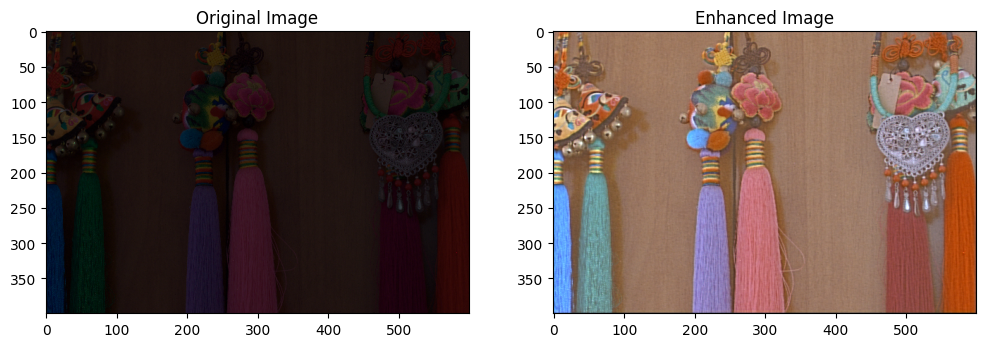

In [ ]:
IMAGE_LOC = '/content/drive/MyDrive/minor/images/image3.png'
original_image, output_image = inferer.infer(IMAGE_LOC)
plot_result(original_image, output_image)
output_image.save('/content/drive/MyDrive/minor/new_img/image3.png')

<ipython-input-18-10b76e958d1e>:30: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  (target_width, target_height), Image.ANTIALIAS


1/1 [==============================] - 12s 12s/step


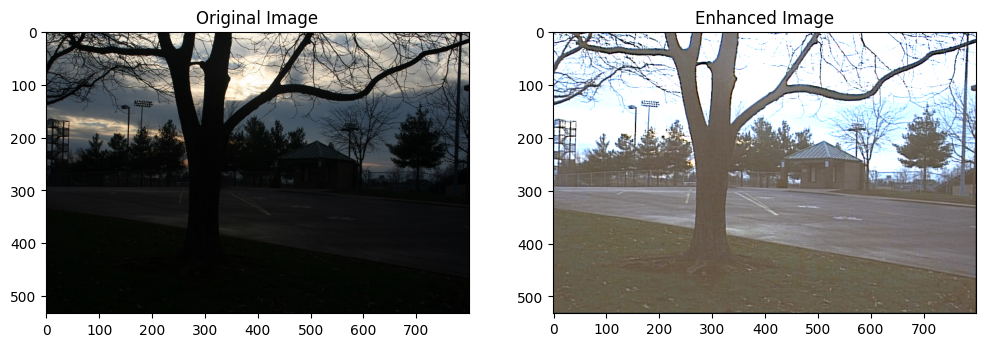

In [ ]:
IMAGE_LOC = '/content/drive/MyDrive/minor/images/image6.jpg'
original_image, output_image = inferer.infer(IMAGE_LOC)
plot_result(original_image, output_image)
output_image.save('/content/drive/MyDrive/minor/new_img/image6.jpg')

<ipython-input-18-10b76e958d1e>:30: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  (target_width, target_height), Image.ANTIALIAS


1/1 [==============================] - 44s 44s/step


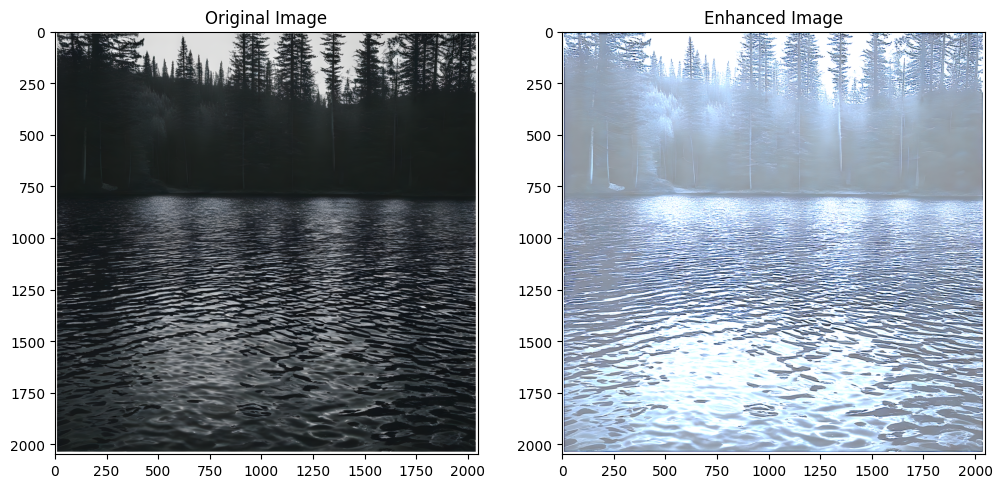

In [ ]:
IMAGE_LOC = '/content/drive/MyDrive/minor/images/image7.png'
original_image, output_image = inferer.infer(IMAGE_LOC)
plot_result(original_image, output_image)
output_image.save('/content/drive/MyDrive/minor/new_img/image11.jpg')

In [ ]:
IMAGE_LOC = '/content/drive/MyDrive/minor/images/image11.jpg'
output_image.save('/content/drive/MyDrive/minor/new_img/image11.jpg')


<ipython-input-18-10b76e958d1e>:30: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  (target_width, target_height), Image.ANTIALIAS


1/1 [==============================] - 10s 10s/step


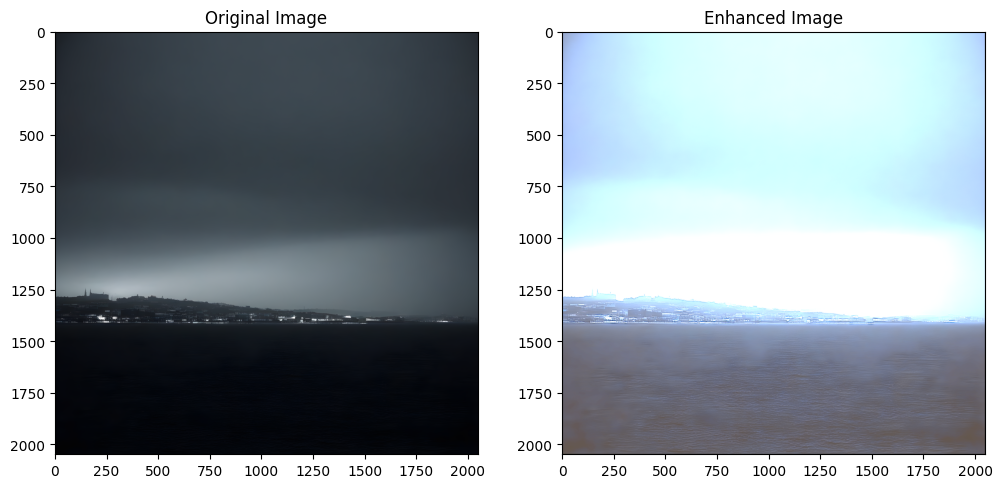

In [ ]:
original_image, output_image = inferer.infer(IMAGE_LOC)
plot_result(original_image, output_image)